# **Image Classification Using Convolutional Neural Networks**

In this notebook, a model based on [convolutional neural networks (CNN)](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) is implemented for image classification using the [CIFAR-10 dataset](https://www.cs.toronto.edu/%7Ekriz/cifar.html). This dataset consists of 60,000 color (RGB) images, with 50,000 used for training and 10,000 for testing.


Better results have been achieved in the notebook [ImageClassification_EfficientNetV2L_CIFAR-10](https://github.com/JersonGB22/ImageClassification-TensorFlow/blob/main/BasicModels/ImageClassification_EfficientNetV2L_CIFAR-10.ipynb), reaching an accuracy of **98.1%** on the test dataset.

## **Imports**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive

## **Parameters**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
epochs = 50
batch_size = 32
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123

## **Load and preprocess the dataset**

In [ ]:
(train_dataset, test_dataset), info = tfds.load("cifar10", split=["train", "test"], as_supervised=True, with_info=True)
info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/root/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learni

In [ ]:
num_classes = info.features["label"].num_classes
class_names = info.features['label'].names

print("Number of classes:", num_classes)
print("Class names:", class_names)

Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### **Prepare the datasets for training**

In [ ]:
train_dataset = (
    train_dataset.
    shuffle(buffer_size, seed=SEED).
    batch(batch_size).
    prefetch(AUTOTUNE)
)

test_dataset = (
    test_dataset.
    batch(batch_size).
    prefetch(AUTOTUNE)
)

In [ ]:
# Take a batch from the training dataset
for images, labels in train_dataset.take(1):
  print(images.shape, labels.shape)

images.numpy().min(), images.numpy().max()

(32, 32, 32, 3) (32,)


(0, 255)

**Function to display and save images**

In [ ]:
def show_images(images, labels, predictions=None, num_examples=36, random=True,
                cmap=None, axis="off", save=False, path=""):

  n = int(np.sqrt(num_examples))
  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  fig, axes = plt.subplots(n, n, figsize=(1.25*n, 1.25*n))

  for i, ax in enumerate(axes.flat):
    ax.imshow(images[indices[i]], cmap=cmap)

    if predictions is not None:
      color = "#00008B" if labels[indices[i]] == predictions[indices[i]] else "red"

      ax.text(
          x=0.5, y=1.11, s=f"Label: {class_names[labels[indices[i]]]}", color=color, fontsize=6.75,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )
      ax.text(
          x=0.5, y=1, s=f"Pred: {class_names[predictions[indices[i]]]}", color=color, fontsize=6.75,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    else:
      ax.text(
          x=0.5, y=1, s=f"Label: {class_names[labels[indices[i]]]}", fontsize=7,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    ax.axis(axis)

  # Save images
  if save:
    plt.savefig(path)

  plt.tight_layout()
  plt.show()

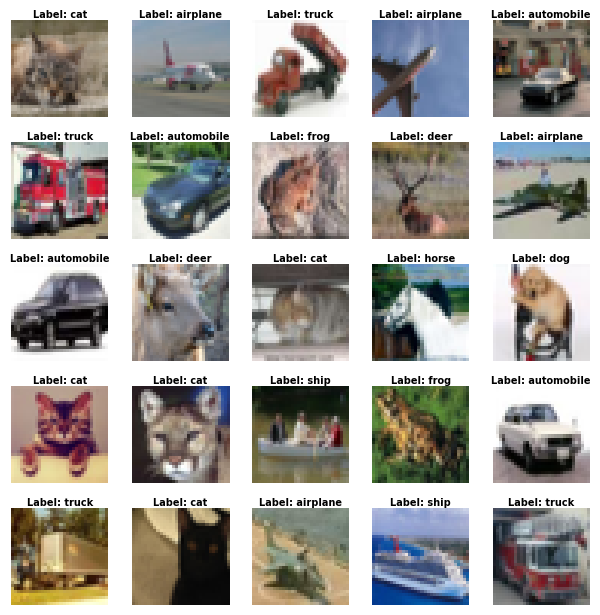

In [ ]:
# Some images from the training dataset
show_images(images, labels, num_examples=25, random=False)

### **Data augmentation**

To combat overfitting, it is essential to use data augmentation techniques, especially since the training dataset is relatively small. Data augmentation will help improve the model's generalization ability in image classification. To achieve this, TensorFlow's `RandomFlip` and `RandomTranslation` layers will be used. These layers are active only during model training and are automatically disabled during inference (evaluation and prediction). Additionally, the `Rescaling` layer will be employed, which is active during both training and inference. This layer normalizes image values to a range of 0-1, which is necessary to ensure uniform scaling of the images, facilitating the model's learning process. It is important to note that the `Rescaling` layer is not part of the data augmentation. These three layers will be used to create a sequential model that will be part of the overall model.

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1/255), #Normalize the images in the range [0; 1]
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1)
], name="data_augmentation")

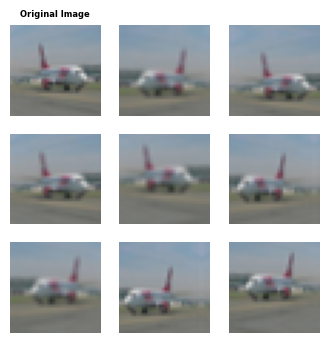

In [ ]:
# Example of data augmentation
id = 1

plt.figure(figsize=(4, 4))
sample_image = images[id][None, :]

for i in range(9):
  ax = plt.subplot(3, 3, i+1)

  # Original image
  if i == 0:
    augmented_image = sample_image
    plt.title("Original Image", fontsize=6, fontweight="bold")

  # Image after applying data augmentation
  else:
    augmented_image = data_augmentation(sample_image)

  plt.imshow(augmented_image[0])
  plt.axis("off")

## **Model building and training**

In [ ]:
def base_cnn(filters=32, dropout_rate=0.15, name=None):
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same", activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same", activation="relu"),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.MaxPool2D(pool_size=2),
      tf.keras.layers.Dropout(dropout_rate)
  ], name=name)

In [ ]:
tf.keras.backend.clear_session() #Clearing Keras memory
#tf.random.set_seed(SEED) #For reproducibility

model = tf.keras.Sequential([
    tf.keras.Input(shape=(32, 32, 3)),
    data_augmentation,
    base_cnn(filters=32, name="block_conv_1"),
    base_cnn(filters=64, name="block_conv_2"),
    base_cnn(filters=128, name="block_conv_3"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)       │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block_conv_1 (Sequential)            │ (None, 16, 16, 32)          │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block_conv_2 (Sequential)            │ (None, 8, 8, 64)            │          55,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block_conv_3 (Sequential)            │ (None, 4, 4, 128)           │         222,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 552,362 (2.11 MB)

 Trainable params: 551,466 (2.10 MB)

 Non-trainable params: 896 (3.50 KB)

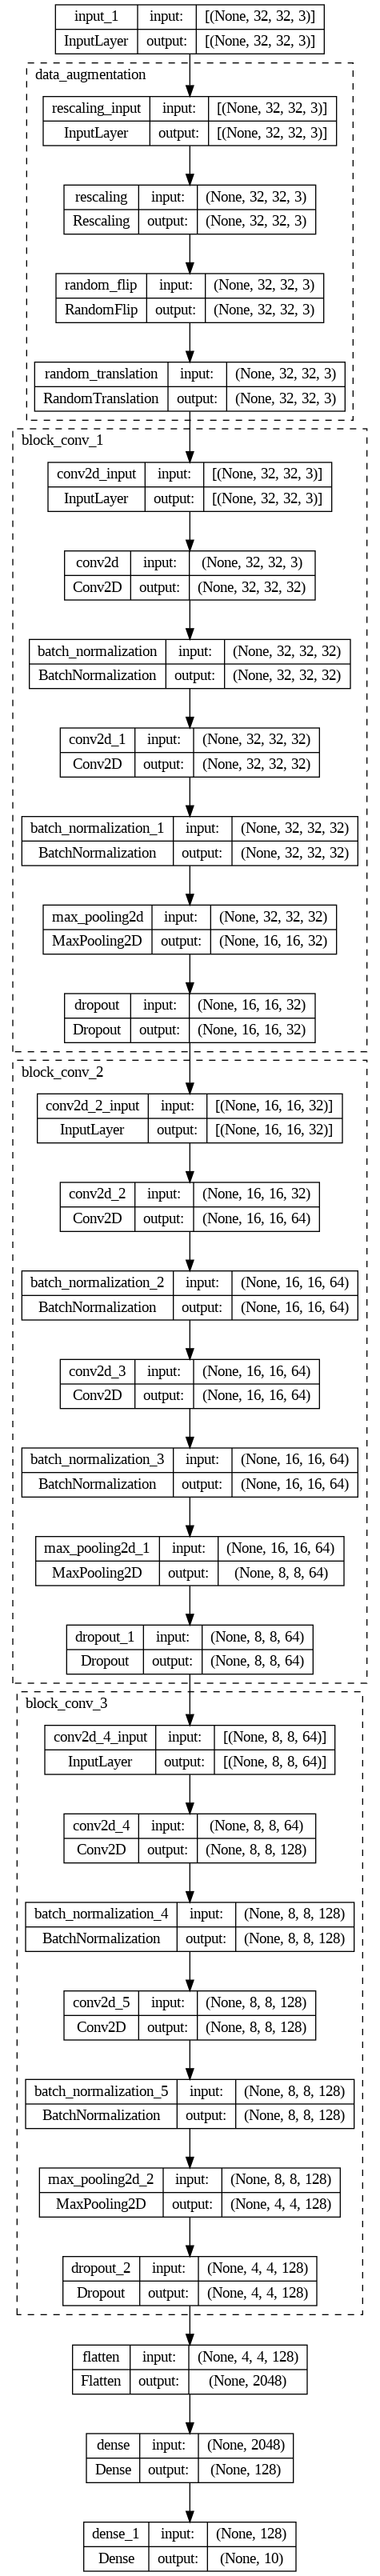

In [ ]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True)

In [ ]:
# Model Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callback to stop training early if validation accuracy does not improve for 5 epochs
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

In [ ]:
# Train the model

#tf.random.set_seed(SEED)
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[callback])

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 40s 20ms/step - accuracy: 0.4005 - loss: 1.6925 - val_accuracy: 0.6119 - val_loss: 1.1150
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.6308 - loss: 1.0482 - val_accuracy: 0.6947 - val_loss: 0.8837
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7007 - loss: 0.8632 - val_accuracy: 0.7417 - val_loss: 0.7329
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - accuracy: 0.7358 - loss: 0.7612 - val_accuracy: 0.7191 - val_loss: 0.8495
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.7584 - loss: 0.6995 - val_accuracy: 0.7118 - val_loss: 0.8885
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 37s 16ms/step - accuracy: 0.7783 - loss: 0.6437 - val_accuracy: 0.7825 - val_loss: 0.6607
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.7885 - loss: 0.6098 - val_accuracy: 0.8065 - val_loss: 0.5853
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.8078 -

**Save the Model**

In [ ]:
trained_model_path = "/content/drive/MyDrive/models/ImageClassification_CNN_CIFAR-10.keras"
model.save(trained_model_path)

## **Model Evaluation**

In [ ]:
print(model.evaluate(train_dataset, verbose=0))
print(model.evaluate(test_dataset, verbose=0))

[0.176367849111557, 0.9380999803543091]
[0.3723377287387848, 0.8823999762535095]


In [1]:
(0.9380999803543091-0.8823999762535095) * 100

5.570000410079956

### **Graphs of the metrics**

In [ ]:
# Function to plot the metrics
def plot_metrics(history=history, metric="loss", renderer=None, epochs=len(history.history["loss"])):
  losses = history.history[metric]
  val_losses = history.history[f"val_{metric}"]
  list_epochs = np.arange(1, epochs+1)
  metric = " ".join([w.capitalize() for w in metric.split("_")])

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name=metric, line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text=metric)
  fig.update_layout(title=f"Evolution of {metric} across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [ ]:
# Interactive graphic
plot_metrics()
plot_metrics(metric="accuracy")

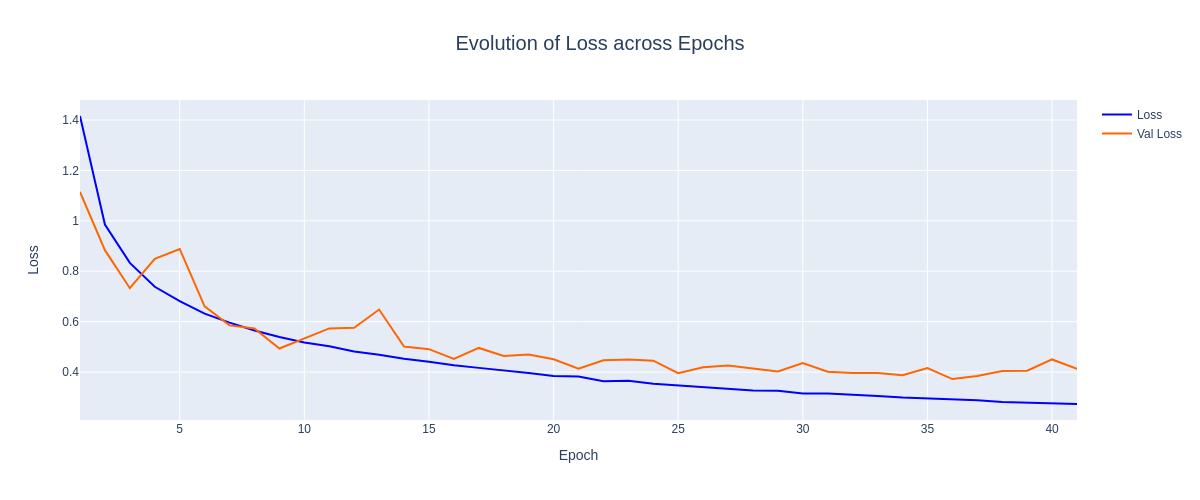

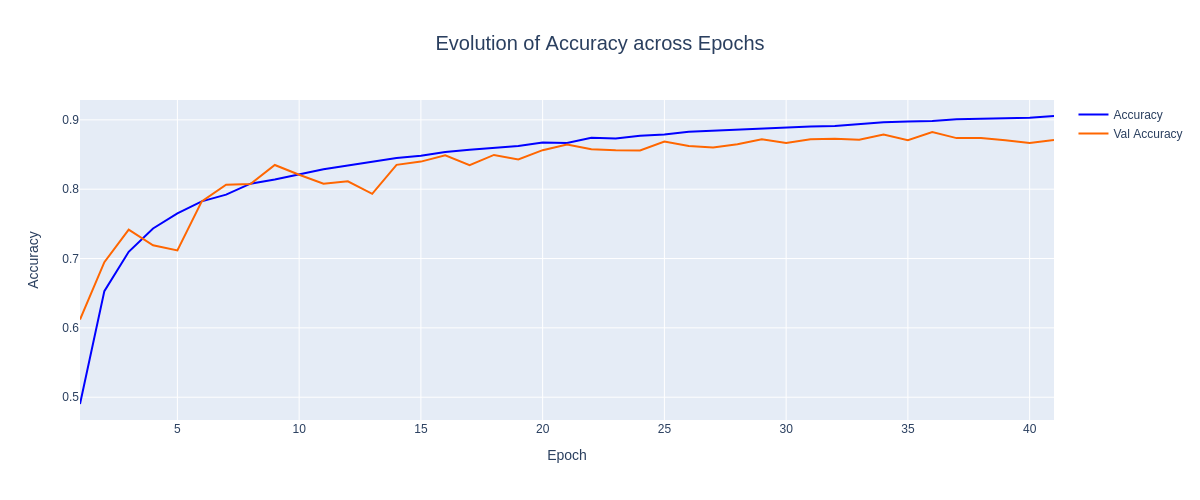

In [ ]:
# Static image for GitHub
plot_metrics(renderer="png")
plot_metrics(metric="accuracy", renderer="png")

### **Confusion Matrix**

In [ ]:
# Extract labels from the test dataset
labels_test = test_dataset.unbatch().map(lambda image, label: label)
labels_test = np.array(list(labels_test.as_numpy_iterator()))

# Generate predictions with the trained model
labels_test_pred = model.predict(test_dataset, verbose=0)
labels_test_pred = np.argmax(labels_test_pred, axis=-1)

# Consolidating the accuracy of the test dataset
np.mean(labels_test == labels_test_pred)

0.8824

Frequency per Label: [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000] 



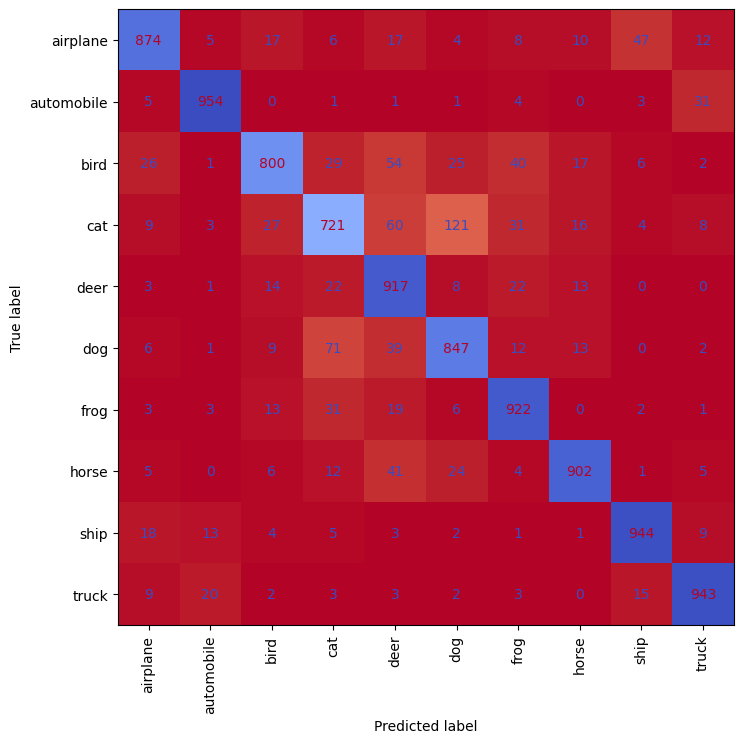

In [ ]:
print("Frequency per Label:", np.unique(labels_test, return_counts=True)[1], "\n")

cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax, colorbar=False, cmap="coolwarm_r", xticks_rotation="vertical");

The test dataset is balanced, with 1,000 images per label. Additionally, the confusion matrix shows that the model has more difficulty distinguishing between the 'cat', 'dog', and 'bird' categories, while it performs better in classifying the 'automobile' category.

## **Predictions on the test dataset**

In [ ]:
# Extract images from the test dataset
images_test = test_dataset.unbatch().map(lambda image, label: image)
images_test = np.array(list(images_test.as_numpy_iterator()))

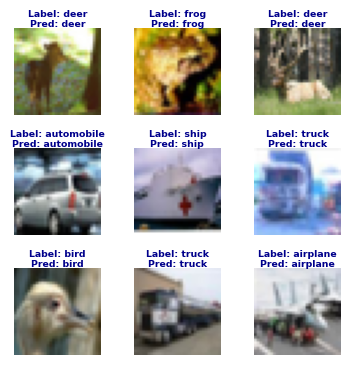

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=9)

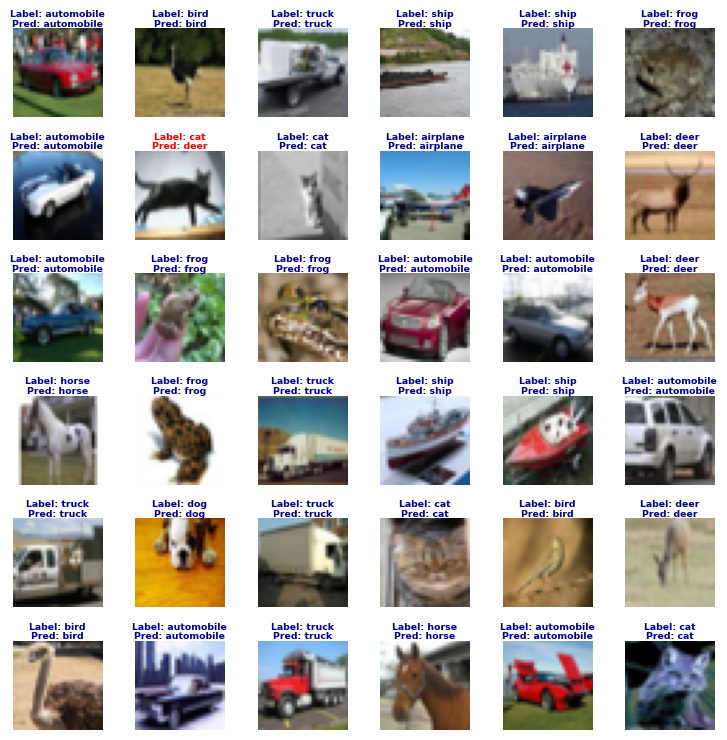

In [ ]:
show_images(images_test, labels_test, labels_test_pred)

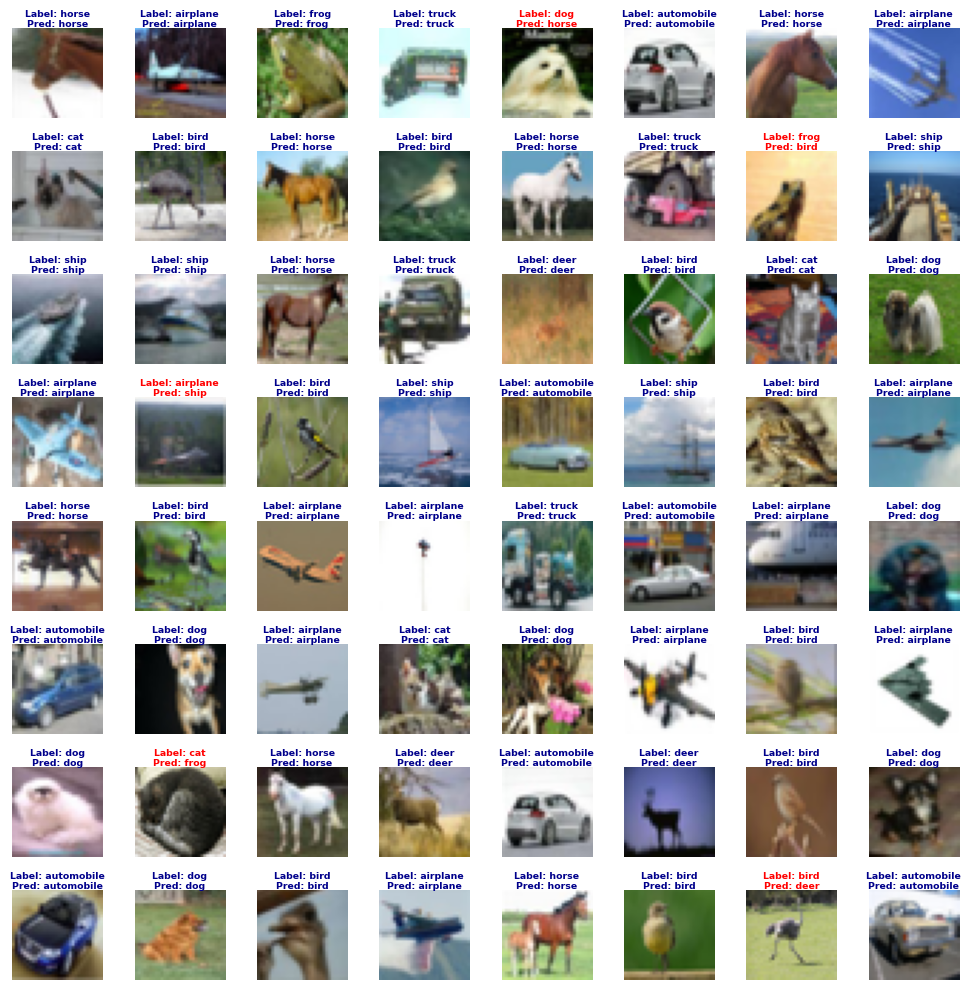

In [ ]:
show_images(images_test, labels_test, labels_test_pred, num_examples=64, random=False)

**Conclusion:** The model achieved an accuracy of **93.81%** on the training dataset and **88.24%** on the test dataset after 36 epochs. This **5.57%** difference suggests some overfitting, despite the use of data augmentation and dropout layers. To further reduce overfitting, one could enhance data augmentation techniques and/or increase the dropout rate; however, this might slightly reduce test accuracy. If training were to continue for more epochs, the training accuracy would likely reach 100%, while test accuracy would begin to decline. However, the early stopping callback prevented excessive overfitting.

To achieve better results, it would be advisable to use a more advanced model architecture, leveraging transfer learning or fine-tuning, which allows for the utilization of state-of-the-art CNNs or Vision Transformers.